<a href="https://colab.research.google.com/github/atusharkm/hello-world/blob/master/NewLSTMRFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [2]:
from datetime import datetime

In [3]:
df = pd.read_excel('Tata_consumer_returns_price_beta.xlsx')

df.columns = ['Date', 'Close', 'Returns', 'Beta', 'Volatility']

df['Date'] = pd.to_datetime(df.Date, format='%d-%m-%Y %H:%M')
df['Date'] = pd.to_datetime(df.Date).dt.date
# df.index = df['Date']

In [4]:
values = df.values

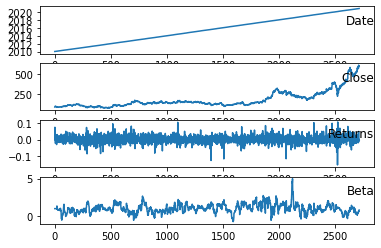

In [5]:
groups = [0, 1, 2, 3]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [6]:
df.head()

,Date,Close,Returns,Beta,Volatility
0,2010-01-04,94.93,0.000000,1.0,0.0
1,2010-01-05,102.29,0.074672,1.0,0.0
2,2010-01-06,103.89,0.015521,1.0,0.0
3,2010-01-07,104.25,0.003459,1.0,0.0
4,2010-01-08,104.77,0.004976,1.0,0.0


In [7]:
df = df.drop(columns = ['Date'])

In [8]:
train_size = int(len(df)*0.8)
# Fitting the RNN to the Training settrain_size = int(len(df_scaled)*0.8)
test_size = len(df) - train_size

train_df,test_df = df[:train_size], df[train_size:len(df)]

In [9]:
df = df.replace('?', np.nan)
df.isnull().sum()

Close         0
Returns       0
Beta          0
Volatility    0
dtype: int64

In [10]:
# df.reset_

In [11]:
df.head()

,Close,Returns,Beta,Volatility
0,94.93,0.000000,1.0,0.0
1,102.29,0.074672,1.0,0.0
2,103.89,0.015521,1.0,0.0
3,104.25,0.003459,1.0,0.0
4,104.77,0.004976,1.0,0.0


In [12]:
# x = []
# x.append('')
# for i in range(1,len(df)):
#   x.append((str(df['Date'][i])))
#   # print((df['Date'][i].strftime("%Y")))

In [13]:
# type(x[0])

In [14]:
# df['Date'] = (x)

In [15]:
# df['Date']=df['Date'].strftime("%Y %m %dd")

In [16]:
# df = df['Date'].astype(str)

In [17]:
df.dtypes[1] == 'float64'

True

In [18]:
train = train_df
scalers={}
for i in train_df.columns:
  # if df.dtypes[i] == 'float64':
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s = np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i] = s_s
  # else:
    # scalers['scaler']
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+ i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [19]:
def split_series(series, n_past, n_future):
  # n_past ==> no of past observations
  # n_future ==> no of future observations
 
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [20]:
n_past = 60
n_future = 10
n_features = 4

In [21]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [22]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 60, 100),    42000       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  [(None, 100),        80400       ['lstm[0][0]']                   
                                 (None, 100),                                                 

In [23]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')

In [24]:
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),verbose=1,callbacks=[reduce_lr])

pred_e2d2=model_e2d2.predict(X_test)

Epoch 1/25
66/66 [==============================] - 17s 154ms/step - loss: 0.0361 - val_loss: 0.1113 - lr: 0.0010
Epoch 2/25
66/66 [==============================] - 8s 126ms/step - loss: 0.0244 - val_loss: 0.1081 - lr: 9.0000e-04
Epoch 3/25
66/66 [==============================] - 8s 125ms/step - loss: 0.0229 - val_loss: 0.0962 - lr: 8.1000e-04
Epoch 4/25
66/66 [==============================] - 8s 126ms/step - loss: 0.0222 - val_loss: 0.1010 - lr: 7.2900e-04
Epoch 5/25
66/66 [==============================] - 8s 127ms/step - loss: 0.0217 - val_loss: 0.1077 - lr: 6.5610e-04
Epoch 6/25
66/66 [==============================] - 8s 128ms/step - loss: 0.0209 - val_loss: 0.1195 - lr: 5.9049e-04
Epoch 7/25
66/66 [==============================] - 8s 127ms/step - loss: 0.0202 - val_loss: 0.1335 - lr: 5.3144e-04
Epoch 8/25
66/66 [==============================] - 8s 128ms/step - loss: 0.0195 - val_loss: 0.1441 - lr: 4.7830e-04
Epoch 9/25
66/66 [==============================] - 8s 128ms/step -

In [25]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [26]:
math.sqrt(mean_squared_error(y_test[:,0], pred_e2d2[:,0]))

34.46302710034423

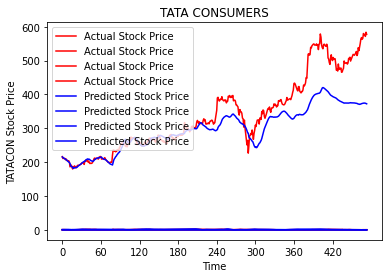

In [27]:
plt.plot(y_test[:,0], color = 'red', label = 'Actual Stock Price')
plt.plot(pred_e2d2[:,0], color = 'blue', label = 'Predicted Stock Price')
plt.title('TATA CONSUMERS' )
plt.xlabel('Time')
plt.ylabel('TATACON Stock Price')
plt.legend()
plt.xticks(np.arange(0,459,60))
plt.show()